In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import mediapy as media
import PIL
import io

import matplotlib.patches
import seaborn as sns
from IPython.display import HTML as html_print


%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

def flow_tensor_to_rgb(flow, flow_mag_range=None, white_bg=False):
    flow_ = flow.detach().cpu().permute(1,2,0).numpy()
    flow_rgb = flow_to_rgb(flow_, flow_mag_range, white_bg)
    return torch.tensor(flow_rgb).permute(2,0,1)[None]

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data as datasets
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

import mediapy as media
import PIL
import io

import matplotlib.patches

from IPython.display import HTML as html_print

## Debug new RNN with GT and base level inputs

In [5]:
T = 3

data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
    is_test=False
)
print(len(movi_dataset))

2022-05-30 19:48:25.967462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dbear/miniconda3/envs/bbnet/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-30 19:48:25.967502: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


250


In [6]:
ex = 0
data = movi_dataset[ex]
data.keys()

movie, frame b'3835' 11


dict_keys(['images', 'objects', 'flow', 'depth'])

In [7]:
for v in data.values():
    print (v.shape)

torch.Size([3, 3, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([3, 2, 256, 256])
torch.Size([3, 1, 256, 256])


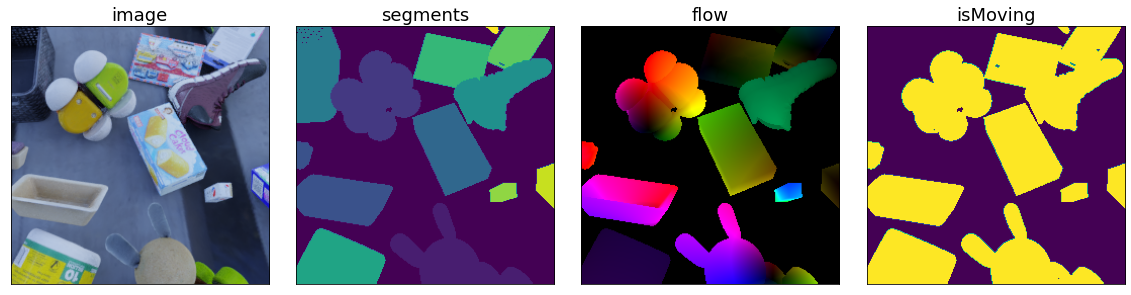

In [8]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
vis_utils.imshow(data['images'], axes[0])
vis_utils.imshow(data['objects'], axes[1])
vis_utils.imshow(data['flow'].abs().sum(1, True) > 0.1, axes[3])
vis_utils.imshow(flow_tensor_to_rgb(data['flow'][0]), axes[2])

titles = ['image', 'segments', 'flow', 'isMoving']
for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=18)
plt.tight_layout()
plt.show()

In [9]:
def get_gt_boot_inputs(data, t=1):
    images, objects, flow = [data[k][None].cuda() for k in ['images', 'objects', 'flow']]
    motion = (flow[:,t].abs().sum(1, True) > 0.1).float()
    boundaries = fprop.get_mask_boundaries(
        fprop.SegmentsToAffinitiesTarget.segments_to_masks(
            objects[:,t,0]))[0].amax(1, True)
    boundaries_motion = boundaries * motion
    orientations = fprop.estimate_boundary_orientations(
        boundaries=boundaries_motion,
        energy=motion,
        radius=3,
        to_circle=False
    )
    orientations = F.normalize(orientations, dim=1, p=2) * boundaries_motion
    return (motion, boundaries_motion, orientations, flow[:,t])

def viz_gt_boot_inputs(data, t=1):
    a, b, c, f = get_gt_boot_inputs(data, t=t)
    im = data['images'][t:t+1]
    fig, axes = plt.subplots(1,5,figsize=(20,4))
    
    plots = [
        im,
        a,
        b, 
        data_utils.FlowToRgb(1.0)(c),
        flow_tensor_to_rgb(f[0])
    ]
    titles = ['image', 'motion', 'boundaries', 'orientations', 'flow']
    for i,ax in enumerate(axes):
        vis_utils.imshow(plots[i], ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=18)
        
    plt.tight_layout()
    plt.show()
    return (im, a, b, c, f)


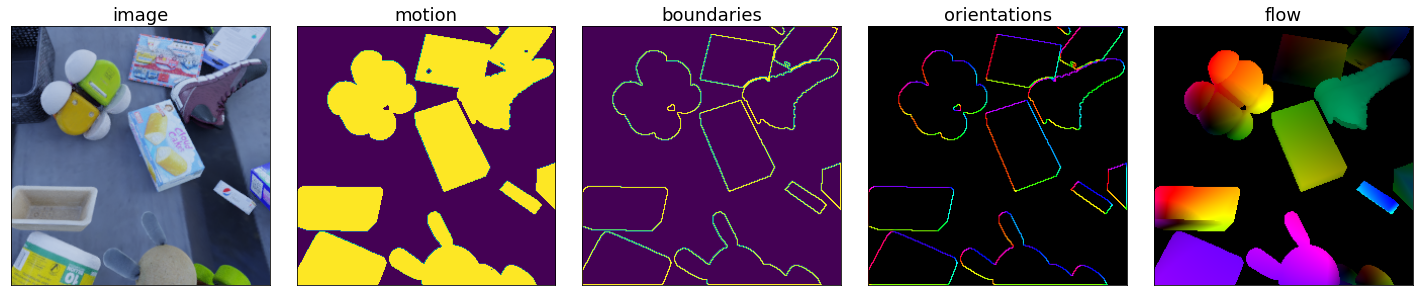

In [10]:
im, a, b, c, f = viz_gt_boot_inputs(data)

In [11]:
toponet = fprop.TopoNet(
    num_iters=10,
    diffusion_steps=100,
    boundary_radius=3,
    boundary_cone_thresh=0.5,
    store_from=0,
    store_every=1,
    num_sample_points=2**14,
    innate_motion_params={'warp_radius': 3, 'patch_radius': 2}
).cuda()

In [15]:
a_mask = (torch.rand(a.shape).to(a.device) > 0.0).float()
a0 = a*a_mask
b0 = b*a_mask
# b0 = b
c0 = c*a_mask
f0 = None
a_out, b_out, c_out, f_out = toponet(
    video=data['images'][None].cuda(),
    motion=None, 
    boundaries=None, 
    orientations=None,
    flow=f0
)

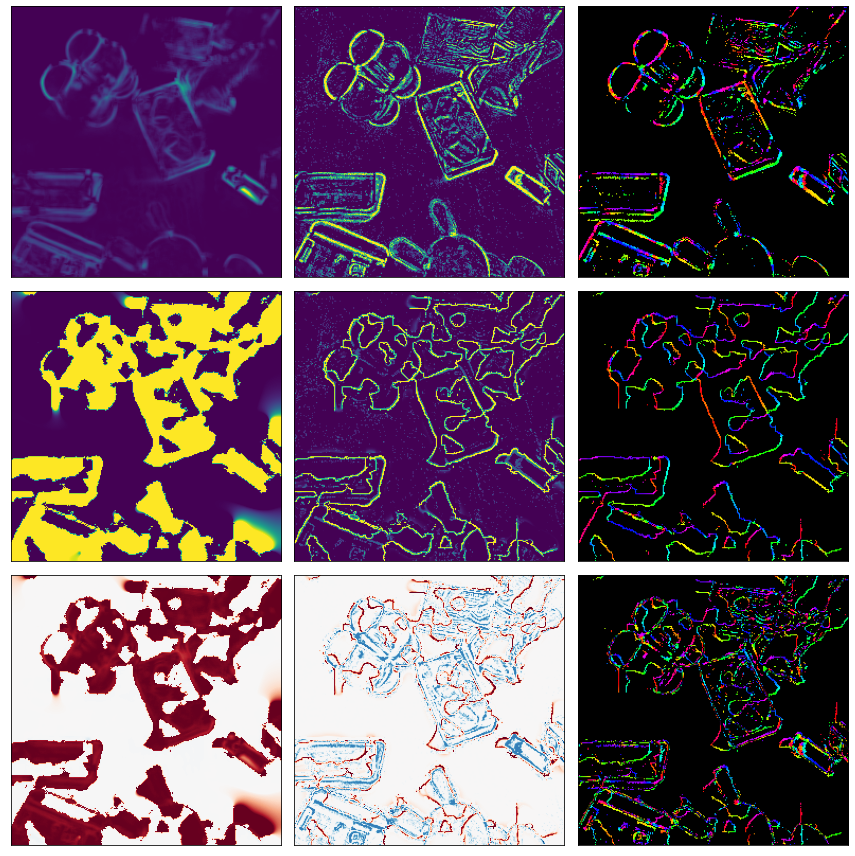

In [16]:
fig, axes = plt.subplots(3,3,figsize=(12,12))
vis_utils.imshow(toponet.hidden_states['motion'][0], axes[0,0])
vis_utils.imshow(toponet.hidden_states['boundaries'][0], axes[0,1])
vis_utils.imshow(data_utils.FlowToRgb()(toponet.hidden_states['orientations'][0]), axes[0,2])
vis_utils.imshow(a_out, axes[1,0])
vis_utils.imshow(b_out, axes[1,1])
vis_utils.imshow(data_utils.FlowToRgb()(c_out), axes[1,2])
vis_utils.imshow(a_out - toponet.hidden_states['motion'][0], axes[2,0], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(b_out - toponet.hidden_states['boundaries'][0], axes[2,1], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(data_utils.FlowToRgb()(c_out - toponet.hidden_states['orientations'][0]), axes[2,2])

for i in range(3):
    for j in range(3):
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
plt.tight_layout()
plt.show()

ex0_innate__motion,ex0_innate__boundaries,ex0_innate__orientations

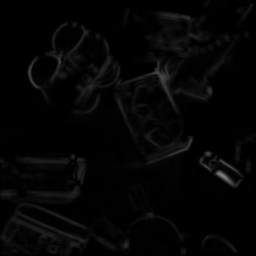
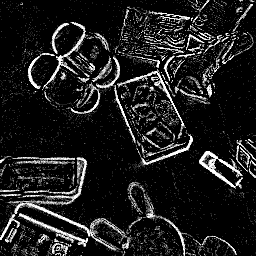
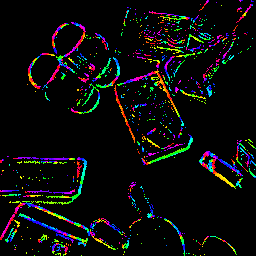

In [18]:
media.set_show_save_dir('/home/dbear/media/toponet/')
fname = 'ex0_innate_'
media.show_videos({
    "%s_motion" % fname: torch.cat(toponet.hidden_states['motion'], 0)[:,0].detach().cpu().numpy(),    
    "%s_boundaries" % fname: torch.cat(toponet.hidden_states['boundaries'], 0)[:,0].detach().cpu().numpy(),
    "%s_orientations" % fname: data_utils.FlowToRgb()(torch.cat(toponet.hidden_states['orientations'], 0)
                                          ).permute(0,2,3,1).detach().cpu().numpy()
},
    fps=4, columns=3, codec='gif'
)

In [19]:
a_mask = toponet.compute_stability_mask(
    toponet.hidden_states['motion'],
    first_state=-7,
    last_state=None,
    delta_thresh=0.0
)

b_mask = toponet.compute_stability_mask(
    toponet.hidden_states['boundaries'],
    first_state=-7,
    last_state=None,
    delta_thresh=0.0
) * a_mask

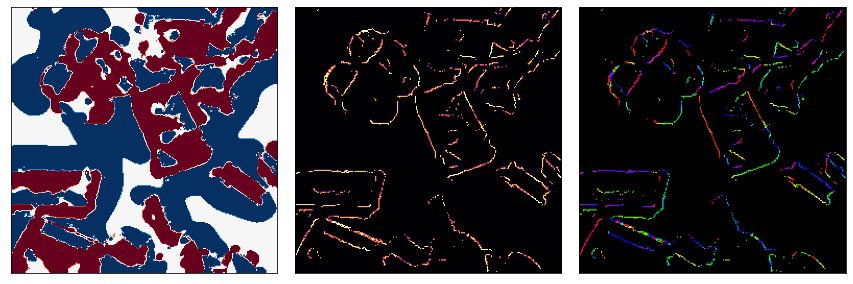

In [20]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
a_sup = 2*a_mask*a_out - a_mask
b_sup = b_mask*b_out*a_out
c_sup = data_utils.FlowToRgb()(b_mask*(b_out > 0.5).float()*c_out)

vis_utils.imshow(a_sup, axes[0], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(b_sup > 0, axes[1], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(c_sup, axes[2])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Debug BootRNN Training

In [7]:
bootrnn = teachers.BootRNN().cuda()

created a new MotionClassifier with 1484643 parameters
created a new BoundaryClassifier with 1484643 parameters
created a new CentroidRegressor with 1486948 parameters


In [17]:
video = data['images'][None].cuda()[...,::4,::4]
preds, targets = bootrnn(torch.cat([video]*2, 0))

In [19]:
targets['motion'][1].shape

torch.Size([2, 1, 64, 64])

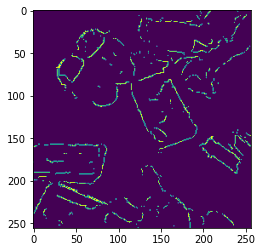

In [35]:
vis_utils.imshow(targets['boundaries'][0] * targets['boundaries'][1] * targets['motion'][0] * targets['motion'][1])

In [1066]:
bootrnn.boot_rnn.hidden_states['motion']

11

In [1086]:
bootrnn.losses['motion'][-1].shape

torch.Size([1, 1, 256, 256])

In [1079]:
bootrnn.students['orientations'].args

Namespace(alternate_corr=False, boundary_path='../checkpoints/40000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth', corr_levels=4, corr_radius=4, dropout=0.0, gate_stride=1, gpus=[0], mixed_precision=False, motion_path='../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth', predict_mask=False, small=True, static_coords=False, static_input=True)